# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import os
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load Data (a sample)

## 1. Train 

In [55]:
path ='../Kaggle_DSB_data/train.csv'
train = pd.read_csv(path, nrows=1000000, parse_dates=['timestamp'])

In [56]:
train = train.set_index(['installation_id','game_session'])

In [57]:
train.head()

event_id               timestamp                                         event_data  event_count  event_code  game_time                          title      type      world
installation_id game_session                                                                                                                                                                                 
0001e90f        45bb1e1b6b50c07b  27253bdc 2019-09-06 17:53:46.937             {"event_code": 2000, "event_count": 1}            1        2000          0        Welcome to Lost Lagoon!      Clip       NONE
                17eeb7f223665f53  27253bdc 2019-09-06 17:54:17.519             {"event_code": 2000, "event_count": 1}            1        2000          0           Magma Peak - Level 1      Clip  MAGMAPEAK
                0848ef14a8dc6892  77261ab5 2019-09-06 17:54:56.302  {"version":"1.0","event_count":1,"game_time":0...            1        2000          0  Sandcastle Builder (Activity)  Activity  MAGMAPEAK
                0848ef14a8dc6892  b2dba42b 2019-09-06 17:54:56.387  {"description":"Let's build a sandcastle! Firs...            2        3010         53  Sandcastle Builder (Activity)  Activity  MAGMAPEAK
                0848ef14a8dc6892  1bb5fbdb 2019-09-06 17:55:03.253  {"description":"Let's build a sandcastle! Firs...            3        3110       6972  Sandcastle Builder (Activity)  Activity  MAGMAPEAK

Noise: game_time =0  and incorrect 

## 2. Train Labels

In [68]:
path_labels ='../Kaggle_DSB_data/train_labels.csv'
train_labels = pd.read_csv(path_labels, nrows=1000000)

In [69]:
train_labels = train_labels.set_index(['installation_id','game_session'])

In [70]:
train_labels.head()

title  num_correct  num_incorrect  accuracy  accuracy_group
installation_id game_session                                                                                        
0006a69f        6bdf9623adc94d89  Mushroom Sorter (Assessment)            1              0       1.0               3
                77b8ee947eb84b4e    Bird Measurer (Assessment)            0             11       0.0               0
                901acc108f55a5a1  Mushroom Sorter (Assessment)            1              0       1.0               3
                9501794defd84e4d  Mushroom Sorter (Assessment)            1              1       0.5               2
                a9ef3ecb3d1acc6a    Bird Measurer (Assessment)            1              0       1.0               3

## 3. Merge all Assessment train data

In [75]:
assessments = pd.merge(train[train.type == 'Assessment'],
                     train_labels, left_index=True, right_index=True, how='inner')

# clean df
assessments = assessments.drop(['title_y','type'],axis=1)\
                         .rename({'title_x':'title'},axis=1)

In [88]:
assessments.head()

event_id               timestamp                                         event_data  event_count  event_code  game_time                         title        world  num_correct  num_incorrect  accuracy  accuracy_group
installation_id game_session                                                                                                                                                                                                                              
0006a69f        6bdf9623adc94d89  3bfd1a65 2019-08-06 05:37:50.020  {"version":"1.0","event_count":1,"game_time":0...            1        2000          0  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  db02c830 2019-08-06 05:37:50.078  {"event_count":2,"game_time":77,"event_code":2...            2        2025         77  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  a1e4395d 2019-08-06 05:37:50.082  {"description":"Pull three mushrooms out of th...            3        3010         77  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  7da34a02 2019-08-06 05:37:52.799  {"coordinates":{"x":199,"y":484,"stage_width":...            4        4070       2784  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3
                6bdf9623adc94d89  28ed704e 2019-08-06 05:37:53.631  {"height":1,"coordinates":{"x":171,"y":519,"st...            5        4025       3625  Mushroom Sorter (Assessment)  TREETOPCITY            1              0       1.0               3

# Feature Engineering

Let's first try to construct "domain-like" features which might infleunce user performance. I'll divide these features into the following categories:

1. Level of game difficulty
2. User Expertise
3. User Focus 
4. Clarity of Game Instructions
5. Other



## 1. Level of game difficulty

a) rate title based on user performance <br>
b) rate world based on user performance <br>



a) Title

In [121]:
pct_corrects = lambda g: round(g.sum()/g.count(),3)
assess_title = assessments.groupby(['title'])[['num_correct']]\
                          .agg(['count','sum', pct_corrects])

In [122]:
# Clean df
assess_title.columns = ['num_assessments', 'num_correct', 'pct_correct']
assess_title['pct_incorrect'] =  1 - assess_title.pct_correct
assess_title.index = [title.split('(')[0].strip() for title in assess_title.index]

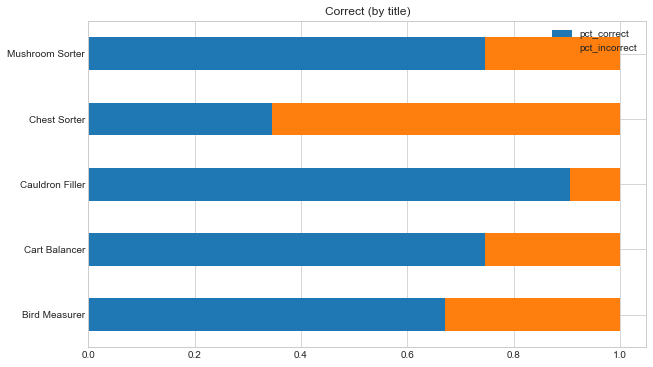

In [137]:
assess_title.loc[:,['pct_correct','pct_incorrect']].plot.barh(stacked=True,figsize=(10, 6), title='Correct (by title)')

In [89]:
assess_title['num_incorrect'] = assess_title.loc[:,('num_correct','count')] -assess_title.loc[:,('num_correct','sum')] 

In [90]:
assess_title

num_correct        num_incorrect
                                   count    sum              
title                                                        
Bird Measurer (Assessment)         18158  12160          5998
Cart Balancer (Assessment)         13438  10028          3410
Cauldron Filler (Assessment)       18007  16321          1686
Chest Sorter (Assessment)          17598   6086         11512
Mushroom Sorter (Assessment)       17908  13354          4554

## 2. User Expertise

a) measure net game time <br>
b) measure net game time per title <br>
c) measure game time per world <br>
d) measure how the performance changes with time <br>
e) measure time of completion of each task <br>

## 3. User focus

a) time of the day user signed in <br>
b) how much time spent per session <br>
c) boredom by playing too much?

## 4. Clarity of game instructions

Game Clarity:<br>
a) rate hints based on user performance <br>
b) check if the user was doing something weird: from coords (e.g. false negatives) <br>
c) check if the user was doing something weird to familiarize himself/herself with the game (e.g. at the beginnig might press randomly)